In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet


Importing plotly failed. Interactive plots will not work.


In [10]:
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')

train_targets_a = pd.read_parquet('../data/A/train_targets.parquet')
train_targets_b = pd.read_parquet('../data/B/train_targets.parquet')
train_targets_c = pd.read_parquet('../data/C/train_targets.parquet')

In [32]:
m = Prophet()
#print(X_train_estimated_a.head())
X_train = pd.concat([X_train_observed_a, X_train_estimated_a])
agg_func = {col: 'mean' for col in X_train.columns[1:]}

X_train_downscaled = X_train.groupby(X_train.index // 4).agg({**{'date_forecast': 'first'}, **agg_func})

ts = pd.DataFrame()
ts["ds"] = pd.to_datetime(X_train_downscaled['date_forecast'])
ts["y"] = train_targets_a['pv_measurement']
print(ts.head())

#X_train['ds'] = X_train['timestamp'] ## Kom tilbake til hit.
#X_train['y'] = train_targets_a['pv_measurement']
#print(X_train['ds'].head())
#print(X_train.shape)
#print(train_targets_a.head())


m.fit(ts)
future = m.make_future_dataframe(periods=30)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

                   ds      y
0 2019-06-02 22:00:00   0.00
1 2019-06-02 23:00:00   0.00
2 2019-06-03 00:00:00   0.00
3 2019-06-03 01:00:00   0.00
4 2019-06-03 02:00:00  19.36


14:20:07 - cmdstanpy - INFO - Chain [1] start processing
14:20:11 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
29693,2022-11-16 01:00:00,-583.612275,-1664.905630,546.374560
29694,2022-11-17 01:00:00,-617.960226,-1689.997908,342.674260
29695,2022-11-18 01:00:00,-604.223885,-1632.132850,400.329728
29696,2022-11-19 01:00:00,-639.085181,-1707.047643,345.361717
29697,2022-11-20 01:00:00,-660.072289,-1655.874712,392.952459


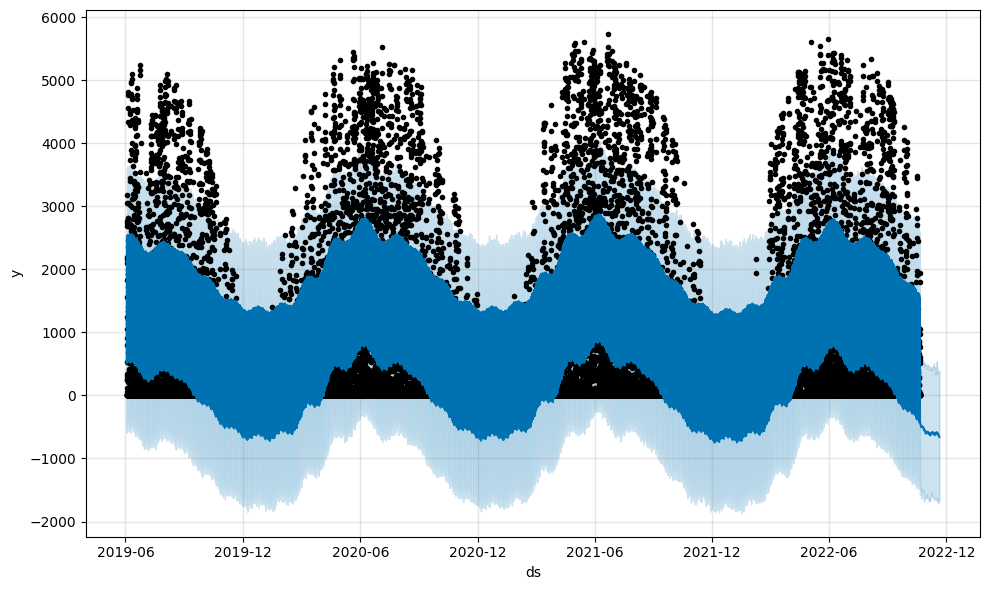

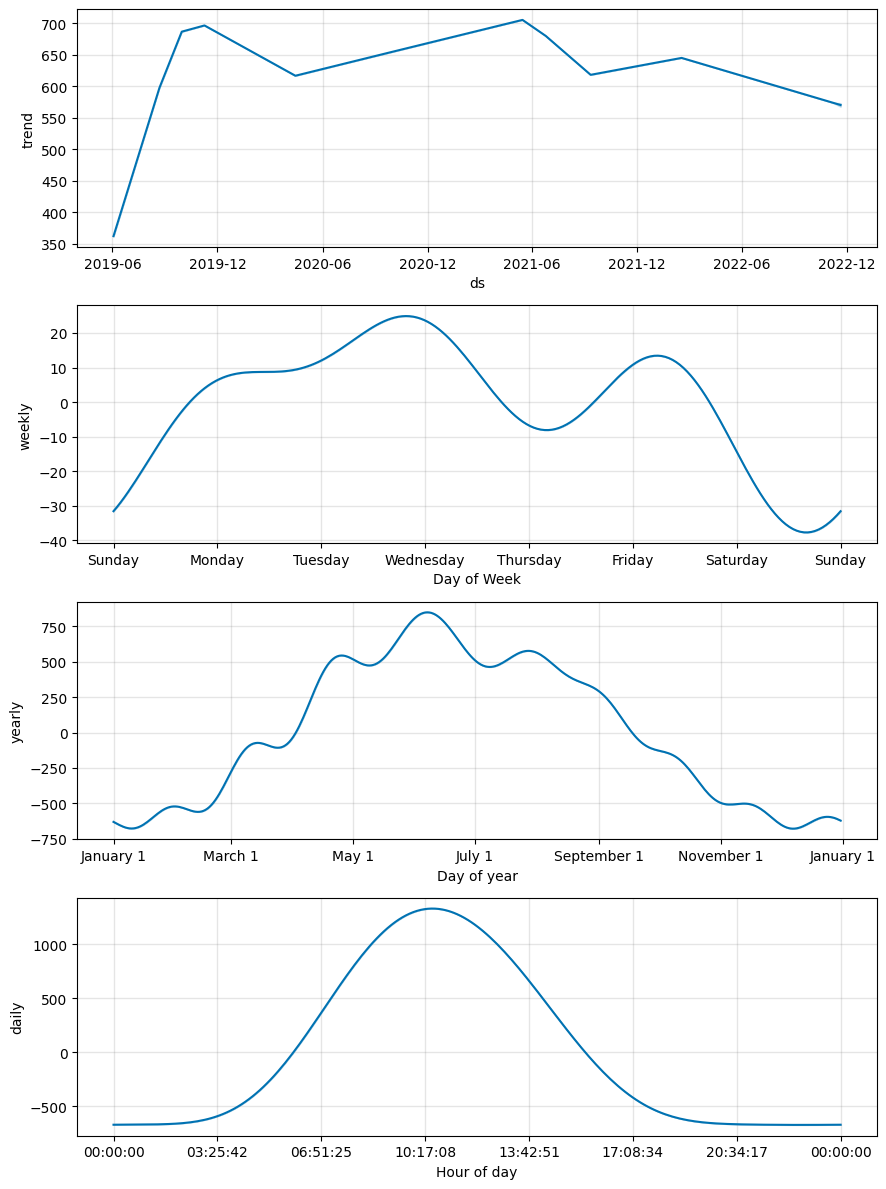

In [33]:
fig1 = m.plot(forecast)
#fig2 = m.plot_components(forecast)

In [ ]:
# y_test_pred = ...

test = pd.read_csv('../data/test.csv')
# test['prediction'] = y_test_pred
sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submission.csv', index=False)